Load modules

In [1]:
from IPython import display

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import trimesh
import trimesh.voxel.creation
import rtree

import glob

In [2]:
from torch.utils.data import Dataset

In [3]:
import os

In [4]:
import scipy.ndimage as ndimage

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [6]:
from os import listdir
from os.path import join

In [7]:
torch.set_printoptions(profile="full")

In [8]:
import torchvision.transforms.functional as TF
from PIL import Image

Load .obj files

In [9]:
obj_folder ='./data/objects'
img_folder ='./data/images'

In [10]:
objects = []
for file in listdir(obj_folder):
    if file.endswith(".stl"):
        m = trimesh.load_mesh(join(obj_folder,file))
        #convert to voxels
        m_vox = trimesh.voxel.creation.voxelize(m,0.3)
        objects.append(m_vox)

        
images = []
for file in listdir(img_folder):
    if file.endswith(".jpg"):
        path = os.path.join(img_folder,file)
        im=Image.open(path)
        image=TF.to_tensor(im).reshape(1,256,256)
        images.append(image)

In [11]:
type(images[0])

torch.Tensor

Reshape tensors with padding

In [12]:
# Define size of the space (pix)
w = 32
l = 32 
h = 64 

In [13]:
def objects_to_matrices(objs):
    vox_matrices = []
    for m in objs:
        object_matrix = torch.from_numpy(m.matrix.astype(int)) # torch.ones(m.matrix.shape)
        scene_matrix = torch.zeros((l,w,h))
            
    # center the matrices in the scene
        low = (int)(scene_matrix.size(0)//2) - (int)(object_matrix.size(0)//2)
        up = low + object_matrix.size(0)
    
        low1 = (int)(scene_matrix.size(1)//2) - (int)(object_matrix.size(1)//2)
        up1 = low1 + object_matrix.size(1)
    
        low2 = (int)(scene_matrix.size(2)//2) - (int)(object_matrix.size(2)//2)
        up2 = low2 + object_matrix.size(2)
    
    
        scene_matrix[low:up,low1:up1,low2:up2] = object_matrix
        vox_matrices.append((scene_matrix))
        
    return vox_matrices
    #print(scene_matrix)
    

In [14]:
# convert to tensors
vox_meshes = objects_to_matrices(objects)
#incomplete_vox_meshes = objects_to_matrices(incomplete_objects)


In [15]:
encoded_objects = []
for object in vox_meshes:
    layers = object[:,:,0]
    layers = layers.reshape(256,4)
    for i in range(63):
        next = object[:,:,i+1]
        next = next.reshape(256,4)
        layers = torch.cat([layers,next],1)
        
    encoded_objects.append(layers.reshape(1,256,256))

    
len(encoded_objects)

20

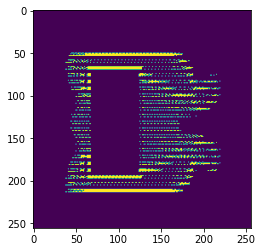

In [16]:
plt.imshow(encoded_objects[0].squeeze())
plt.show()


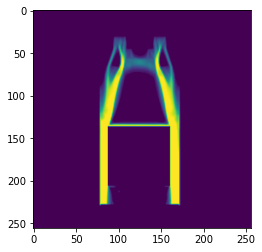

In [17]:
plt.imshow(images[0].squeeze())
plt.show()

In [18]:
# #show sample

# colors = np.empty(vox_meshes[0].shape, dtype=object)
# fig = plt.figure(figsize=(6,8))
# ax = fig.gca(projection='3d')
# ax.voxels(test_rearr, edgecolor='cyan')
# plt.show()

In [19]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]        
        #x,y = self.transform(image,mask)
        return image,mask
        
    def __len__(self):
        return len(self.images)


In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
len_images=len(objects)
train_size =0.8
train_data = image_dataset(encoded_objects[:int(len_images*train_size)], images[:int(len_images*train_size)], train=True)
train_loader = DataLoader(train_data, batch_size = 2, shuffle = True)

test_data = image_dataset(encoded_objects[int(len_images*train_size):], images[int(len_images*train_size):], train = False)
test_loader = DataLoader(test_data, batch_size = 2, shuffle = False)

In [22]:
len(train_data)

16

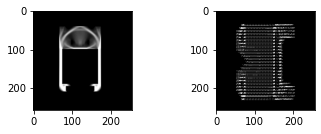

torch.Size([1, 256, 256])


In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_data[1][1][0],cmap ='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_data[1][0][0],cmap ='gray')
plt.show()
#print(train_data[1][1])
print(train_data[0][0].shape)

### Networks

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [26]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) # 
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8) 
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
      
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))

        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
 
        x = self.out(x)
    
        return x

In [27]:
model = UNet()
model = model.to(device)
#model.apply(weights_init)
#print(model)

In [28]:
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
# The training loop
epochs = 800
total_steps = len(train_loader)

for epoch in range(epochs):
    total_train = 0
    correct_train = 0
    for i, (images, masks) in enumerate(train_loader):
        #print(masks.shape)

        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(masks)
        
        softmax = torch.nn.functional.log_softmax(outputs, dim=1)
        loss = criterion(outputs, images)
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += images.nelement()
        correct_train += (predicted == masks).sum().item()
        train_accuracy = 100 * correct_train / total_train
         
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}, Accuracy:{train_accuracy}")

Epoch [1/800], Step [0/8], Loss: 0.660961, Accuracy:167.279052734375
Epoch [2/800], Step [0/8], Loss: 0.408861, Accuracy:176.67083740234375
Epoch [3/800], Step [0/8], Loss: 0.340988, Accuracy:169.0582275390625
Epoch [4/800], Step [0/8], Loss: 0.293275, Accuracy:172.1588134765625
Epoch [5/800], Step [0/8], Loss: 0.262778, Accuracy:173.016357421875
Epoch [6/800], Step [0/8], Loss: 0.228718, Accuracy:173.14605712890625
Epoch [7/800], Step [0/8], Loss: 0.226192, Accuracy:168.93310546875
Epoch [8/800], Step [0/8], Loss: 0.218949, Accuracy:169.500732421875
Epoch [9/800], Step [0/8], Loss: 0.251510, Accuracy:162.7410888671875
Epoch [10/800], Step [0/8], Loss: 0.214217, Accuracy:163.19580078125
Epoch [11/800], Step [0/8], Loss: 0.206258, Accuracy:171.26007080078125
Epoch [12/800], Step [0/8], Loss: 0.215294, Accuracy:168.4783935546875
Epoch [13/800], Step [0/8], Loss: 0.171060, Accuracy:172.28240966796875
Epoch [14/800], Step [0/8], Loss: 0.180638, Accuracy:168.15185546875
Epoch [15/800], Step

Epoch [117/800], Step [0/8], Loss: 0.074901, Accuracy:169.44122314453125
Epoch [118/800], Step [0/8], Loss: 0.087935, Accuracy:166.94183349609375
Epoch [119/800], Step [0/8], Loss: 0.076003, Accuracy:173.88916015625
Epoch [120/800], Step [0/8], Loss: 0.065981, Accuracy:171.52099609375
Epoch [121/800], Step [0/8], Loss: 0.075690, Accuracy:172.454833984375
Epoch [122/800], Step [0/8], Loss: 0.060064, Accuracy:177.2979736328125
Epoch [123/800], Step [0/8], Loss: 0.071367, Accuracy:167.279052734375
Epoch [124/800], Step [0/8], Loss: 0.067592, Accuracy:168.93310546875
Epoch [125/800], Step [0/8], Loss: 0.071993, Accuracy:172.03826904296875
Epoch [126/800], Step [0/8], Loss: 0.058813, Accuracy:173.3795166015625
Epoch [127/800], Step [0/8], Loss: 0.070831, Accuracy:168.87359619140625
Epoch [128/800], Step [0/8], Loss: 0.066073, Accuracy:172.28240966796875
Epoch [129/800], Step [0/8], Loss: 0.055615, Accuracy:175.76141357421875
Epoch [130/800], Step [0/8], Loss: 0.081622, Accuracy:163.23242187

Epoch [231/800], Step [0/8], Loss: 0.010965, Accuracy:175.79803466796875
Epoch [232/800], Step [0/8], Loss: 0.020912, Accuracy:164.24102783203125
Epoch [233/800], Step [0/8], Loss: 0.015878, Accuracy:171.3470458984375
Epoch [234/800], Step [0/8], Loss: 0.015932, Accuracy:163.6871337890625
Epoch [235/800], Step [0/8], Loss: 0.012512, Accuracy:167.7703857421875
Epoch [236/800], Step [0/8], Loss: 0.011784, Accuracy:169.0093994140625
Epoch [237/800], Step [0/8], Loss: 0.015313, Accuracy:171.0662841796875
Epoch [238/800], Step [0/8], Loss: 0.007692, Accuracy:175.79803466796875
Epoch [239/800], Step [0/8], Loss: 0.013333, Accuracy:166.94183349609375
Epoch [240/800], Step [0/8], Loss: 0.013412, Accuracy:171.0662841796875
Epoch [241/800], Step [0/8], Loss: 0.008993, Accuracy:165.53192138671875
Epoch [242/800], Step [0/8], Loss: 0.009357, Accuracy:163.763427734375
Epoch [243/800], Step [0/8], Loss: 0.012302, Accuracy:167.2027587890625
Epoch [244/800], Step [0/8], Loss: 0.006946, Accuracy:169.25

Epoch [345/800], Step [0/8], Loss: 0.000208, Accuracy:167.950439453125
Epoch [346/800], Step [0/8], Loss: 0.000348, Accuracy:170.33843994140625
Epoch [347/800], Step [0/8], Loss: 0.000198, Accuracy:169.93408203125
Epoch [348/800], Step [0/8], Loss: 0.000201, Accuracy:169.48699951171875
Epoch [349/800], Step [0/8], Loss: 0.000182, Accuracy:175.0701904296875
Epoch [350/800], Step [0/8], Loss: 0.000165, Accuracy:177.2979736328125
Epoch [351/800], Step [0/8], Loss: 0.000355, Accuracy:163.232421875
Epoch [352/800], Step [0/8], Loss: 0.000195, Accuracy:172.95684814453125
Epoch [353/800], Step [0/8], Loss: 0.000171, Accuracy:179.19464111328125
Epoch [354/800], Step [0/8], Loss: 0.000259, Accuracy:171.0662841796875
Epoch [355/800], Step [0/8], Loss: 0.000167, Accuracy:167.75665283203125
Epoch [356/800], Step [0/8], Loss: 0.000283, Accuracy:162.664794921875
Epoch [357/800], Step [0/8], Loss: 0.000191, Accuracy:168.15185546875
Epoch [358/800], Step [0/8], Loss: 0.000136, Accuracy:175.56762695312

Epoch [460/800], Step [0/8], Loss: 0.000052, Accuracy:170.79315185546875
Epoch [461/800], Step [0/8], Loss: 0.000059, Accuracy:164.78118896484375
Epoch [462/800], Step [0/8], Loss: 0.000039, Accuracy:173.57330322265625
Epoch [463/800], Step [0/8], Loss: 0.000054, Accuracy:168.87359619140625
Epoch [464/800], Step [0/8], Loss: 0.000063, Accuracy:171.26007080078125
Epoch [465/800], Step [0/8], Loss: 0.000042, Accuracy:175.79803466796875
Epoch [466/800], Step [0/8], Loss: 0.000050, Accuracy:173.82965087890625
Epoch [467/800], Step [0/8], Loss: 0.000044, Accuracy:171.71478271484375
Epoch [468/800], Step [0/8], Loss: 0.000072, Accuracy:164.5233154296875
Epoch [469/800], Step [0/8], Loss: 0.000048, Accuracy:171.3470458984375
Epoch [470/800], Step [0/8], Loss: 0.000049, Accuracy:170.86944580078125
Epoch [471/800], Step [0/8], Loss: 0.000052, Accuracy:168.62945556640625
Epoch [472/800], Step [0/8], Loss: 0.000047, Accuracy:170.79315185546875
Epoch [473/800], Step [0/8], Loss: 0.000042, Accuracy

Epoch [574/800], Step [0/8], Loss: 0.000023, Accuracy:176.4404296875
Epoch [575/800], Step [0/8], Loss: 0.000020, Accuracy:180.11627197265625
Epoch [576/800], Step [0/8], Loss: 0.000019, Accuracy:170.7916259765625
Epoch [577/800], Step [0/8], Loss: 0.000024, Accuracy:168.0755615234375
Epoch [578/800], Step [0/8], Loss: 0.000023, Accuracy:171.36077880859375
Epoch [579/800], Step [0/8], Loss: 0.000021, Accuracy:167.2027587890625
Epoch [580/800], Step [0/8], Loss: 0.000019, Accuracy:175.76141357421875
Epoch [581/800], Step [0/8], Loss: 0.000018, Accuracy:173.21014404296875
Epoch [582/800], Step [0/8], Loss: 0.000020, Accuracy:168.93310546875
Epoch [583/800], Step [0/8], Loss: 0.000028, Accuracy:166.94183349609375
Epoch [584/800], Step [0/8], Loss: 0.000020, Accuracy:171.3470458984375
Epoch [585/800], Step [0/8], Loss: 0.000018, Accuracy:171.71478271484375
Epoch [586/800], Step [0/8], Loss: 0.000019, Accuracy:172.28240966796875
Epoch [587/800], Step [0/8], Loss: 0.000021, Accuracy:167.2790

Epoch [688/800], Step [0/8], Loss: 0.000011, Accuracy:173.150634765625
Epoch [689/800], Step [0/8], Loss: 0.000010, Accuracy:171.52099609375
Epoch [690/800], Step [0/8], Loss: 0.000018, Accuracy:167.620849609375
Epoch [691/800], Step [0/8], Loss: 0.000012, Accuracy:173.18267822265625
Epoch [692/800], Step [0/8], Loss: 0.000013, Accuracy:165.3350830078125
Epoch [693/800], Step [0/8], Loss: 0.000011, Accuracy:171.3470458984375
Epoch [694/800], Step [0/8], Loss: 0.000010, Accuracy:172.052001953125
Epoch [695/800], Step [0/8], Loss: 0.000012, Accuracy:168.15185546875
Epoch [696/800], Step [0/8], Loss: 0.000010, Accuracy:175.76141357421875
Epoch [697/800], Step [0/8], Loss: 0.000009, Accuracy:177.52838134765625
Epoch [698/800], Step [0/8], Loss: 0.000010, Accuracy:171.47979736328125
Epoch [699/800], Step [0/8], Loss: 0.000011, Accuracy:173.18267822265625
Epoch [700/800], Step [0/8], Loss: 0.000010, Accuracy:179.388427734375
Epoch [701/800], Step [0/8], Loss: 0.000010, Accuracy:167.964172363

In [40]:
# #inverse procedure from 2d to 3d

def inverse_encoding(encoded_object):
    
    zeros = torch.zeros(encoded_object.shape)
    
    c = torch.chunk(encoded_object, 64, dim=2)
    chunks=[]
    for chunk in c:
        ch = chunk.reshape(32,32)
        chunks.append(ch)
    
    rearranged = torch.stack(chunks,2)
#colors = np.empty(vox_meshes[0].shape, dtype=object)
#     fig = plt.figure(figsize=(6,8))
#     ax = fig.gca(projection='3d')
#     ax.voxels(rearranged, edgecolor='cyan')
#     plt.show()
#     rearranged.shape
    
    c1= c[30].reshape(32,32)
    print(c1.shape)
#     plt.imshow(c1.cpu())
#     plt.show()
      

    ones = rearranged.__ge__(0.75) 
    return ones

    

loss: tensor(1.0215, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 170.892333984375
torch.Size([32, 32])
torch.Size([32, 32])


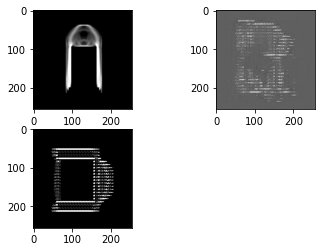

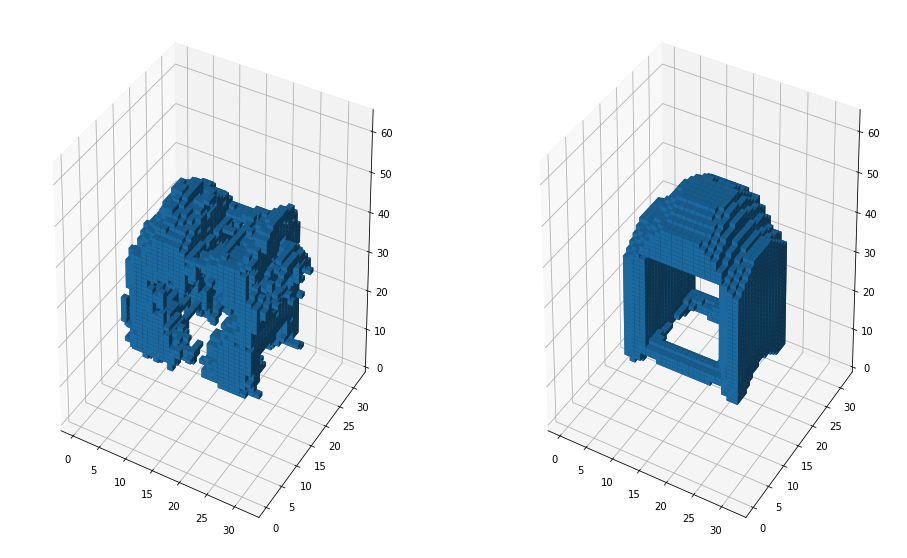

loss: tensor(1.2940, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 170.892333984375
torch.Size([32, 32])
torch.Size([32, 32])


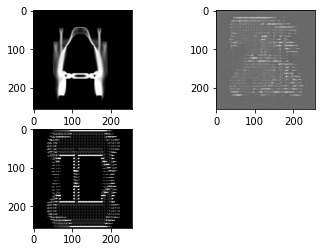

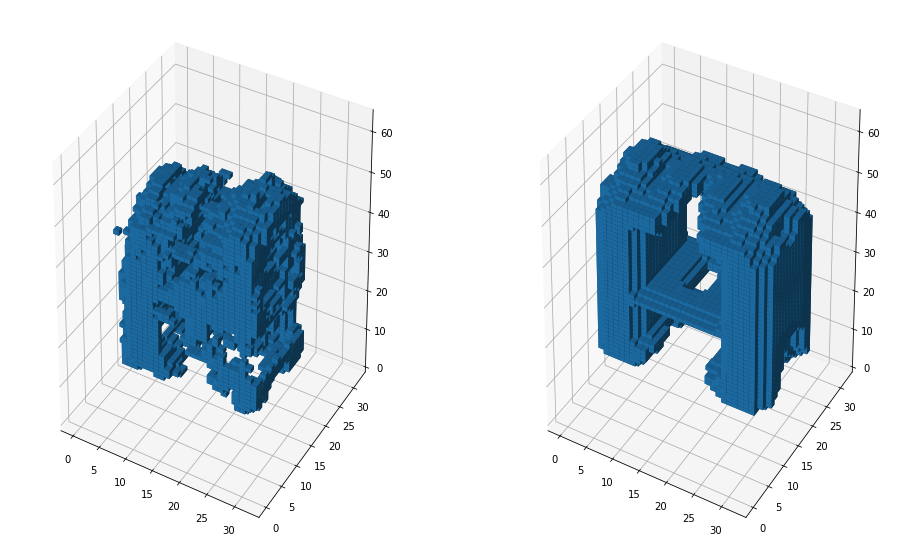

In [49]:
total_test = 0
correct_test = 0

for i, (images, masks) in enumerate(test_loader):
    
#     #blur masks-2 in the batch
#     masks[0] = torch.from_numpy(gaussian_filter(masks[0],10))
#     masks[1] = torch.from_numpy(gaussian_filter(masks[1],1))
    
#     fig = plt.figure()
#     ax1 = fig.add_subplot(2,2,1)
#     ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    
    masks = masks.to(device)
    images = images.to(device)
    output = model(masks)
    softmax = torch.nn.functional.log_softmax(output, dim=1)
    loss = criterion(output, images)
   
    print("loss:", loss)
    
     # accuracy
    _, predicted = torch.max(output.data, 1)
    total_test += images.nelement()
    correct_test += (predicted == masks).sum().item()
    test_accuracy = 100 * correct_train / total_train
    print("test accuracy:", test_accuracy)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()),cmap = 'gray')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()),cmap = 'gray')
    
    new_object = inverse_encoding(output[0])
    gt_object = inverse_encoding(images[0])
    
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
#    fig = plt.figure(figsize=(6,8))
#     ax1 = fig.gca(projection='3d')
    ax1.voxels(new_object)
    
#    ax2 = fig.gca(projection='3d')
    ax2.voxels(gt_object)

    plt.show()

In [37]:
verts, faces, normals, values = skimage.measure.marching_cubes(torch.Tensor.cpu(new_object).detach().numpy(),0)

In [34]:
import skimage
import skimage.measure

In [38]:
finMesh = trimesh.Trimesh(verts,faces)
finMesh = trimesh.smoothing.filter_humphrey(finMesh, alpha=0.1, beta=0.3, iterations=15, laplacian_operator=None)
finMesh.export('dMesh_s.obj')

'# https://github.com/mikedh/trimesh\nv 7.04109589 0.24866785 51.00000000\nv 8.03668541 7.92498358 45.49613908\nv 7.93112758 8.11695673 43.02783035\nv 8.04341730 7.64760190 8.96194801\nv 7.85182696 16.16157255 32.69667278\nv 8.00000000 16.00000000 24.95890411\nv 7.85168227 15.99981167 40.08571190\nv 7.97630435 16.13192574 46.90749024\nv 8.01471780 15.94925416 28.68117105\nv 7.24588445 15.74481005 12.12842163\nv 8.06503532 16.16161282 45.68810858\nv 8.18264702 15.81696901 10.98342094\nv 8.95890411 16.00000000 35.00000000\nv 7.47565574 16.11675006 51.14718653\nv 8.00000000 16.00000000 25.04109589\nv 7.97812780 16.03123522 41.94321128\nv 7.98666781 24.41274933 41.37763624\nv 8.11775590 23.92621626 13.38881209\nv 7.95280833 23.96094102 21.02162845\nv 7.77698047 23.82426998 11.89131192\nv 7.95796985 24.09670688 11.05764376\nv 7.35427131 23.75220137 44.02746801\nv 8.19815187 24.15108380 10.20264848\nv 7.28827854 24.07481290 43.03787172\nv 8.09147240 23.88443234 26.39478464\nv 8.02767651 23.8